# <center>Построение регрессий: коэффициенты Бета и Альфа, MSE на тестовых и тренировочных выборках </center>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [206]:
returns = pd.read_csv('daily_returns.csv', sep=';')
returns

DATE month  year     RUGBITR5Y         IMOEX          GAZP  \
0     20140108   jan  2014   0,000365854  -0,000737831   0,013729977   
1     20140109   jan  2014  -0,000670486   0,001558793   0,009830336   
2     20140110   jan  2014  -0,000426959    0,00303082   0,007282954   
3     20140113   jan  2014   0,001159385   0,005369575  -0,004366812   
4     20140114   jan  2014   0,000426647  -0,004210441  -0,011791775   
...        ...   ...   ...           ...           ...           ...   
1504  20191224   dec  2019   0,000620853  -0,001061372  -0,000509804   
1505  20191225   dec  2019   0,000678637   0,000082492  -0,006356182   
1506  20191226   dec  2019     0,0009882   0,000273851   0,003356367   
1507  20191227   dec  2019    0,00058072   0,006201203    0,01184573   
1508  20191230   dec  2019   0,000831882  -0,001507964  -0,002761464   

              SBER         SBERP          LKOH          MGNT  ...  \
0     -0,007279345  -0,018238994   -0,01562657   0,022105863  ...   
1     -0,001935024  -0,002434337   0,010208769  -0,017957596  ...   
2      0,012244898    0,00385307   0,006316002  -0,060107892  ...   
3      0,010584677   0,015225179   0,004770034  -0,022674288  ...   
4     -0,010074813   -0,01373661  -0,010544201   0,018829085  ...   
...            ...           ...           ...           ...  ...   
1504  -0,000522508   0,007703677  -0,000246629   0,009431138  ...   
1505  -0,002533478   0,004400196    0,00008223   0,013198873  ...   
1506   0,000806322  -0,004646429   0,000657787   0,009660422  ...   
1507   0,015388334   0,006535367   0,010682005  -0,006088721  ...   
1508   0,010672062   0,008392226   0,003089431  -0,000875146  ...   

            HML_23        RMW_23        CMA_23 SMB (3 factor model)_23  \
0      0,005513491   -0,00095784  -0,000809752             0,010620055   
1      0,014103149   -0,00830003   0,015102439            -0,004133597   
2      0,003260961  -0,000755445   0,004165778             0,001347571   
3     -0,002426623  -0,001296674   0,011167197            -0,000416282   
4     -0,011430147  -0,004959725  -0,003835653             0,003030643   
...            ...           ...           ...                     ...   
1504   0,002507639   0,002000752   -0,00139001             0,004327537   
1505  -0,005607534   0,012309883    0,00318666             0,000162819   
1506   0,000762811  -0,002207893  -0,003837872             0,007110657   
1507  -0,001553343  -0,007986448  -0,000407782            -0,000610866   
1508  -0,002543892   0,002413329  -0,000562059             0,001499931   

     SMB (5 factor model)_23        HML_22        RMW_22        CMA_22  \
0                0,011580132   0,003213689   0,001787216   0,001163593   
1               -0,005063835   0,016986258  -0,006672909   0,008413208   
2                0,001512424  -0,001969619   0,002935168   0,004044423   
3               -0,001450708   -0,00550185  -0,001169664   0,007844841   
4                0,002658845  -0,004264437   0,000214463   0,000135966   
...                      ...           ...           ...           ...   
1504             0,004294049  -0,000237389   0,001599378   0,004230479   
1505               0,0018925  -0,005491965   0,007884396   0,001176749   
1506             0,006063611  -0,000986536  -0,001279315  -0,003610623   
1507            -0,000992258   0,001528073  -0,004685641   0,000205862   
1508             0,001686994  -0,000334238  -0,000222777  -0,000892572   

     SMB (3 factor model)_22 SMB (5 factor model)_22  
0                0,012033843             0,012489659  
1               -0,000129772            -0,003028863  
2                0,002442164             0,002269774  
3               -0,000674751            -0,001541792  
4                0,001895922             0,002783117  
...                      ...                     ...  
1504               0,0046893             0,004921135  
1505             0,000186977             0,001314774  
1506             0,007022217             0,

In [207]:
returns = returns.dropna(axis='columns', inplace=False) # Оставляем только столбцы без пропущенных значений
                                                        # Для таких тикеров и будем строить регрессии

In [208]:
import warnings
warnings.filterwarnings('ignore')
for col in returns.columns[3:]:
    returns[col] = returns[col].str.replace(',', '.')
    returns[col] = returns[col].astype(float)

In [198]:
returns.head() # Поменяли запятые на точки

DATE month  year  RUGBITR5Y     IMOEX      GAZP      SBER     SBERP  \
0  20140108   jan  2014   0.000366 -0.000738  0.013730 -0.007279 -0.018239   
1  20140109   jan  2014  -0.000670  0.001559  0.009830 -0.001935 -0.002434   
2  20140110   jan  2014  -0.000427  0.003031  0.007283  0.012245  0.003853   
3  20140113   jan  2014   0.001159  0.005370 -0.004367  0.010585  0.015225   
4  20140114   jan  2014   0.000427 -0.004210 -0.011792 -0.010075 -0.013737   

       LKOH      MGNT  ...    HML_23    RMW_23    CMA_23  \
0 -0.015627  0.022106  ...  0.005513 -0.000958 -0.000810   
1  0.010209 -0.017958  ...  0.014103 -0.008300  0.015102   
2  0.006316 -0.060108  ...  0.003261 -0.000755  0.004166   
3  0.004770 -0.022674  ... -0.002427 -0.001297  0.011167   
4 -0.010544  0.018829  ... -0.011430 -0.004960 -0.003836   

   SMB (3 factor model)_23  SMB (5 factor model)_23    HML_22    RMW_22  \
0                 0.010620                 0.011580  0.003214  0.001787   
1                -0.004134                -0.005064  0.016986 -0.006673   
2                 0.001348                 0.001512 -0.001970  0.002935   
3                -0.000416                -0.001451 -0.005502 -0.001170   
4                 0.003031                 0.002659 -0.004264  0.000214   

     CMA_22  SMB (3 factor model)_22  SMB (5 factor model)_22  
0  0.001164                 0.012034                 0.012490  
1  0.008413                -0.000130                -0.003029  
2  0.004044                 0.002442                 0.002270  
3  0.007845                -0.000675                -0.001542  
4  0.000136                 0.001896                 0.002783  

[5 rows x 54 columns]

In [187]:
returns.describe()

DATE         year    RUGBITR5Y        IMOEX         GAZP  \
count  1.509000e+03  1509.000000  1509.000000  1509.000000  1509.000000   
mean   2.016576e+07  2016.508946     0.000320     0.000545     0.000550   
std    1.706542e+04     1.706426     0.005914     0.010870     0.015992   
min    2.014011e+07  2014.000000    -0.088110    -0.107911    -0.138937   
25%    2.015071e+07  2015.000000    -0.000773    -0.005309    -0.008346   
50%    2.017011e+07  2017.000000     0.000445     0.000441    -0.000150   
75%    2.018071e+07  2018.000000     0.001582     0.006804     0.008615   
max    2.019123e+07  2019.000000     0.093758     0.052552     0.163620   

              SBER        SBERP         LKOH         MGNT         SNGS  ...  \
count  1509.000000  1509.000000  1509.000000  1509.000000  1509.000000  ...   
mean      0.000831     0.000887     0.000872    -0.000447     0.000549  ...   
std       0.020114     0.019356     0.015657     0.019464     0.017140  ...   
min      -0.170432    -0.134424    -0.080985    -0.115457    -0.103369  ...   
25%      -0.009914    -0.009061    -0.008067    -0.010233    -0.008421  ...   
50%       0.000217     0.000714     0.000744    -0.001133     0.000000  ...   
75%       0.011776     0.010742     0.009308     0.009515     0.008054  ...   
max       0.127316     0.107595     0.096802     0.103864     0.151663  ...   

            HML_23       RMW_23       CMA_23  SMB (3 factor model)_23  \
count  1509.000000  1509.000000  1509.000000              1509.000000   
mean      0.006124    -0.005408     0.000053                 0.004143   
std       0.237435     0.197789     0.008144                 0.158479   
min      -0.054698    -7.676080    -0.051346                -0.053754   
25%      -0.005468    -0.005273    -0.004655                -0.004627   
50%      -0.000017    -0.000400     0.000136                 0.000066   
75%       0.005612     0.004662     0.004888                 0.004951   
max       9.216159     0.048755     0.032347                 6.148351   

       SMB (5 factor model)_23       HML_22       RMW_22       CMA_22  \
count              1509.000000  1509.000000  1509.000000  1509.000000   
mean                  0.003538     0.003261    -0.002712     0.003077   
std                   0.136279     0.117623     0.102600     0.120307   
min                  -0.056334    -0.029168    -3.977812    -0.031730   
25%                  -0.004389    -0.004009    -0.003989    -0.003595   
50%                   0.000172     0.000164    -0.000133     0.000017   
75%                   0.004668     0.004222     0.003747     0.003899   
max                   5.285317     4.561949     0.037000     4.666894   

       SMB (3 factor model)_22  SMB (5 factor model)_22  
count              1509.000000              1509.000000  
mean                  0.003094                 0.002985  
std                   0.117761                 0.113597  
min                  -0.054505                -0.063824  
25%                  -0.004581                -0.004459  
50%                   0.000155                 0.000232  
75%                   0.004531                 0.004581  
max                   4.564482                 4.402140  

[8 rows x 53 columns]

In [209]:
# Переменные факторов и активов для построения регрессий (Дневные данные)

risk_free = returns['RUGBITR5Y'] # безрисковый актив
market = returns['IMOEX'] # рыночная доходность
assets = returns[returns.columns[5:-10].drop('IRAO')]
factors_3_23 = returns[['SMB (3 factor model)_23', 'HML_23']] # факторы для 3-факторной модели с портфелями 2х3
factors_3_22 = returns[['SMB (3 factor model)_22', 'HML_22']] # факторы для 3-факторной модели с портфелями 2х2
factors_5_23 = returns[['SMB (5 factor model)_23', 'HML_23', 'RMW_23', 'CMA_23']] # факторы для 5-факторной модели с портфелями 2х3
factors_5_22 = returns[['SMB (5 factor model)_22', 'HML_22', 'RMW_22', 'CMA_22']] # факторы для 5-факторной модели с портфелями 2х2

In [210]:
# Избыточная дневная доходность - целевая переменная
excess_returns = pd.DataFrame()
for col in assets.columns:
    excess_returns[col] = assets[col] - risk_free
excess_returns.head()

GAZP      SBER     SBERP      LKOH      MGNT      SNGS     SNGSP  \
0  0.013364 -0.007645 -0.018605 -0.015992  0.021740 -0.009617 -0.010169   
1  0.010501 -0.001265 -0.001764  0.010879 -0.017287  0.014236  0.003904   
2  0.007710  0.012672  0.004280  0.006743 -0.059681 -0.001749  0.006953   
3 -0.005526  0.009425  0.014066  0.003611 -0.023834  0.015744  0.019872   
4 -0.012218 -0.010501 -0.014163 -0.010971  0.018402 -0.001856  0.000464   

       NVTK      ROSN      GMKN  ...      MVID      MSTT      MAGN      MTLR  \
0 -0.008811 -0.004522 -0.024987  ...  0.004696  0.012457  0.004590  0.007362   
1 -0.009822  0.000547 -0.001271  ... -0.005048  0.004491 -0.002206  0.009873   
2  0.004705  0.002328  0.015018  ... -0.012645  0.005203  0.002762  0.003466   
3  0.023237 -0.007924  0.047546  ... -0.009669 -0.004724  0.004597 -0.013281   
4  0.005118  0.005595 -0.014689  ... -0.001896 -0.009073  0.002435 -0.006562   

       SVAV      NMTP      BSPB      AKRN      PLZL      MSNG  
0 -0.008819  0.009561  0.008815 -0.023312  0.018456  0.006881  
1 -0.009708 -0.010307  0.012227  0.024156 -0.009384 -0.003441  
2  0.011913  0.045079  0.001642 -0.006716  0.001189 -0.002440  
3 -0.001406 -0.011680  0.010979  0.001269 -0.001540  0.003211  
4 -0.006599  0.010171  0.007009  0.003162 -0.002965 -0.007297  

[5 rows x 38 columns]

In [211]:
# Рыночная избыточная доходность - рыночный фактор
market -= risk_free

Теперь посчитаем месячную доходность

In [213]:
ret = pd.DataFrame()
for col in returns.columns[3:]:
    ret[col] = 1 + returns[col]

In [216]:
months = returns['month'].unique()
years = returns['year'].unique()

In [217]:
# Список из рассматриваемых периодов (месяц, год)
m_y = []
for i in years:
    for j in months:
        m_y.append([j, i])

In [229]:
# Создаем датасет с месячными доходностями
monthly_returns = {}
for t in range(len(m_y)):
    m = [m_y[t][0]]
    year = [m_y[t][1]]
    index = ret.loc[returns['month'].isin(m)].loc[returns['year'].isin(year)].index
    for col in ret.columns:
        monthly_returns[col] = monthly_returns.get(col, []) + [(np.prod(ret.loc[index, :][col]))]
monthly_returns = pd.DataFrame(monthly_returns)

In [230]:
for col in monthly_returns.columns:
    monthly_returns[col] = monthly_returns[col] - 1

In [231]:
monthly_returns['m_y'] = m_y # Последний столбец - период

In [232]:
monthly_returns.tail()

RUGBITR5Y     IMOEX      GAZP      SBER     SBERP      LKOH      MGNT  \
67   0.014039  0.000197 -0.020051 -0.039788 -0.039478  0.029274 -0.025099   
68   0.008897  0.002606 -0.026922  0.015656  0.031351  0.001487 -0.035772   
69   0.026335  0.053437  0.150952  0.031531  0.057463  0.098747 -0.091625   
70   0.005368  0.014302 -0.009462 -0.003874 -0.000235  0.036827  0.015780   
71   0.011754  0.037644 -0.004426  0.088768  0.074353  0.005132  0.043253   

        SNGS     SNGSP      NVTK  ...    RMW_23    CMA_23  \
67  0.014412  0.035485 -0.023947  ...  0.017166 -0.053824   
68  0.289617  0.161730  0.018944  ... -0.036604 -0.056266   
69  0.214689  0.005873  0.036269  ... -0.045224 -0.072348   
70  0.025581 -0.042197 -0.067941  ...  0.007037 -0.010573   
71  0.144444  0.045303 -0.004418  ... -0.002702 -0.020328   

    SMB (3 factor model)_23  SMB (5 factor model)_23    HML_22    RMW_22  \
67                 0.028217                 0.024218 -0.041642 -0.008549   
68                -0.006408                -0.017494  0.044519 -0.015357   
69                -0.055214                -0.064983  0.038972 -0.063142   
70                 0.005778                -0.002015  0.027304  0.002752   
71                -0.011718                -0.016310 -0.005996 -0.005464   

      CMA_22  SMB (3 factor model)_22  SMB (5 factor model)_22          m_y  
67 -0.023625                 0.022051                 0.021841  [aug, 2019]  
68 -0.010982                -0.004823                -0.008799  [sep, 2019]  
69 -0.048382                -0.055407                -0.067281  [oct, 2019]  
70  0.035793                 0.009642                 0.010381  [nov, 2019]  
71  0.017742                -0.012388                -0.010533  [dec, 2019]  

[5 rows x 52 columns]

In [233]:
# Переменные факторов и активов для построения регрессий по месячной доходности 

risk_free_month = monthly_returns['RUGBITR5Y'] # безрисковый актив
market_month = monthly_returns['IMOEX'] # рыночная доходность
assets_month = monthly_returns[monthly_returns.columns[2:-11].drop('IRAO')]
factors_3_23_month = monthly_returns[['SMB (3 factor model)_23', 'HML_23']] # факторы для 3-факторной модели с портфелями 2х3
factors_3_22_month = monthly_returns[['SMB (3 factor model)_22', 'HML_22']] # факторы для 3-факторной модели с портфелями 2х2
factors_5_23_month = monthly_returns[['SMB (5 factor model)_23', 'HML_23', 'RMW_23', 'CMA_23']] # факторы для 5-факторной модели с портфелями 2х3
factors_5_22_month = monthly_returns[['SMB (5 factor model)_22', 'HML_22', 'RMW_22', 'CMA_22']] # факторы для 5-факторной модели с портфелями 2х2

In [234]:
# Избыточная доходность - целевая переменная
excess_returns_month = pd.DataFrame()
for col in assets_month.columns:
    excess_returns_month[col] = assets_month[col] - risk_free_month
excess_returns_month.head()

GAZP      SBER     SBERP      LKOH      MGNT      SNGS     SNGSP  \
0  0.089181 -0.024912 -0.037819  0.017049 -0.045081 -0.000923  0.019708   
1 -0.042175 -0.038498  0.003544 -0.014189  0.042361  0.013913  0.060776   
2 -0.018768 -0.072925 -0.100088  0.006284 -0.067530 -0.046886 -0.046759   
3 -0.035951 -0.121128 -0.092376 -0.027049 -0.113839 -0.023183 -0.011824   
4  0.088627  0.153732  0.129339  0.034968  0.234890 -0.004194  0.036602   

       NVTK      ROSN      GMKN  ...      MVID      MSTT      MAGN      MTLR  \
0  0.018517  0.025841  0.036213  ... -0.222477 -0.056703 -0.018691 -0.030261   
1  0.043717 -0.005403  0.110820  ...  0.021747 -0.091281 -0.109117 -0.353390   
2 -0.138360 -0.030802 -0.011419  ... -0.096095 -0.157413 -0.091964 -0.029782   
3 -0.013634 -0.037066  0.105788  ...  0.034723  0.009724  0.049653 -0.009721   
4  0.071988  0.003398  0.027403  ...  0.159283  0.115423  0.139340  0.254882   

       SVAV      NMTP      BSPB      AKRN      PLZL      MSNG  
0 -0.117959  0.044101 -0.007906  0.060242 -0.079659 -0.037219  
1 -0.064184 -0.030414 -0.089225 -0.016275  0.020017  0.010202  
2 -0.235873 -0.141346 -0.026536 -0.079579 -0.188743 -0.053567  
3  0.051917  0.043803 -0.079401  0.145684 -0.067888 -0.054754  
4  0.090893 -0.032280  0.088024  0.132996 -0.036069  0.095442  

[5 rows x 38 columns]

In [235]:
# Рыночная избыточная доходность - рыночный фактор
market_month -= risk_free_month

In [236]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

 ## <center> План </center> 
Для каждой вариации модели *(CAPM, 3 факторная, 5 факторная)* строим регрессию следующими способами:

1. **Дневная доходность**

       а) Обучение на всем периоде (2014 - 2019), считаем ошибки на обучающей выборке
       б) Обучение на периоде (2014 - 2018), прогнозирование для 2019 года, считаем ошибки отдельно на обучающей выборке и на тестовой

2. **Дневная доходность с трехмесячным плавающим окном**

       Обучение с плавающим окном в 3 месяца до декабря 2018, получаем 58 оценко коэффициента Бета и Альфа, затем получаем одну оценку усреднением и прогнозируем доходность на 2019 с учетом средней оценки

3. **Месячная доходность**

       а) Обучение на всем периоде (2014 - 2019), считаем ошибки на обучающей выборке
       б) Обучение на периоде (2014 - 2018), прогнозирование месячной доходности для 2019 года, считаем ошибки отдельно на обучающей выборке и на тестовой



Для многофакторных моделей рассматриваются 2 разветвления и для каждого регрессия посчитана перечисленными выше способами:

    i) Факторы были построеным на основе портфелей 2x3 (меньшая диверсификация)
    ii) Факторы были построеным на основе портфелей 2x2 (бОльшая диверсификация)
    
*Предварительно предполагаю, что в работу стоит включить варианты с построением на периоде 2014-2018 и прогнозированием на 2019*

# <center> CAPM </center>

## *Дневная доходность*

In [237]:
y = excess_returns.to_numpy()
X = market.to_numpy().reshape(-1, 1)
CAPM = LinearRegression()
CAPM.fit(X, y)

LinearRegression()

In [238]:
# Коэффициенты Бета
betas_CAPM = list(zip(excess_returns.columns, CAPM.coef_))

In [239]:
# Коэффициенты Альфа
alphas_CAPM = list(zip(excess_returns.columns, CAPM.intercept_))

In [240]:
print(f"Средний коэффициент \u03B1: {CAPM.intercept_.mean()}")

Средний коэффициент α: 0.00015705297653068973


In [241]:
# Средний показатель R2
print(f"R2 на выборке (2014-2019): {r2_score(CAPM.predict(X), y)}")

R2 на выборке (2014-2019): -4.137902020361567


In [242]:
# R2 для каждого актива
r2_CAPM = list(zip(excess_returns.columns, r2_score(CAPM.predict(X), y, multioutput='raw_values')))

In [243]:
# Средний показатель MSE
print(f"MSE на выборке (2014-2019): {mean_squared_error(CAPM.predict(X), y)}")

MSE на выборке (2014-2019): 0.00035510061663135905


In [244]:
# MSE для каждого актива
mse_CAPM = list(zip(excess_returns.columns, mean_squared_error(CAPM.predict(X), y, multioutput='raw_values')))

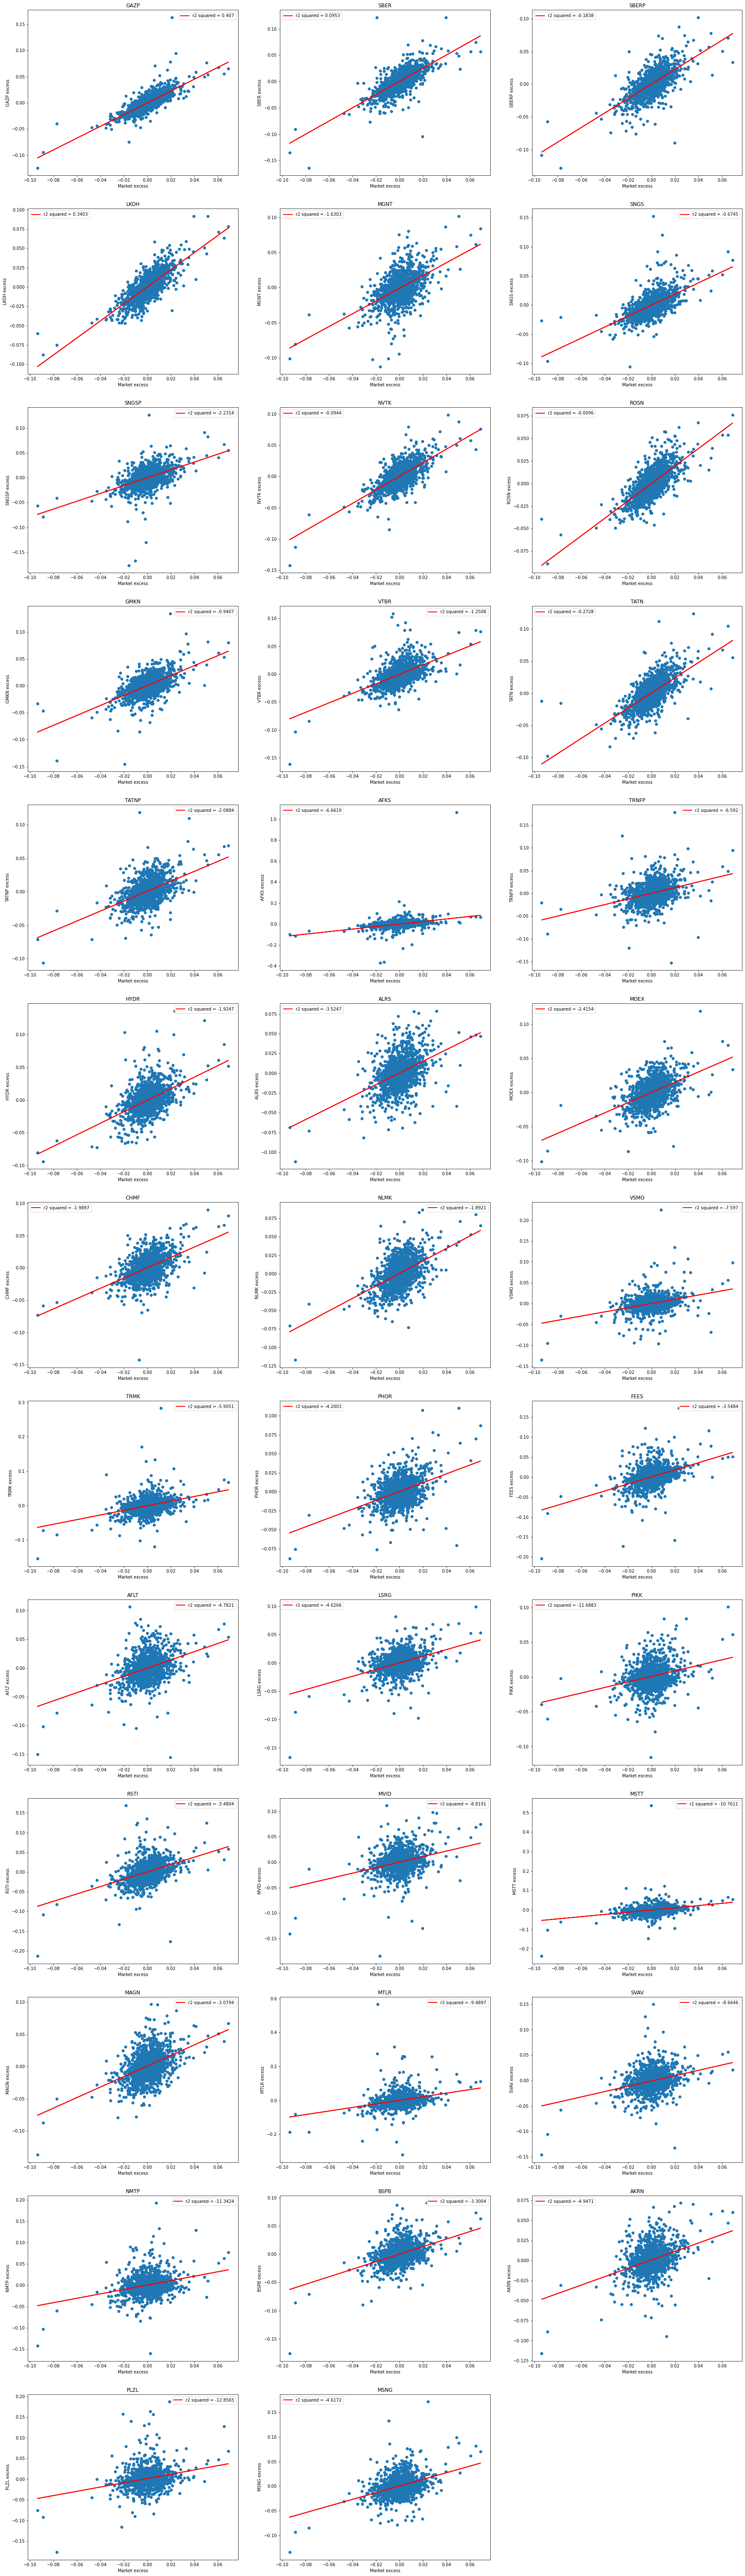

In [241]:
import matplotlib.gridspec as gridspec
import itertools
gs = gridspec.GridSpec(13, 3)

fig = plt.figure(figsize=(30,110))
for tick, grd, i in zip(excess_returns.columns,
                        itertools.product(list(range(13)), list(range(3))),
                       range(len(excess_returns.columns))):
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plt.scatter(x = market, y = excess_returns[tick])
    plt.plot(market, CAPM.predict(X)[:, i], c='red', linewidth=2, 
             label=f"r2 squared = {round(r2_score(CAPM.predict(X), y, multioutput='raw_values')[i], 4)}")
    
    plt.xlabel("Market excess")
    plt.ylabel(f"{tick} excess")
    plt.legend()
    plt.title(f'{excess_returns.columns[i]}')

plt.show();

#### *Обучение до 2019, на 2019 тестирование*

In [29]:
y = excess_returns[:1256].to_numpy()
X = market.to_numpy()[:1256].reshape(-1, 1)
CAPM = LinearRegression()
CAPM.fit(X, y)

LinearRegression()

In [30]:
print(f"Средний коэффициент \u03B1: {CAPM.intercept_.mean()}")

Средний коэффициент α: -0.8178213958219936


In [31]:
prediction = CAPM.predict(market.to_numpy()[1257:].reshape(-1, 1)) # Предсказание для 2019 года
print(f"R2 на тренировочной выборке (2014-2018): {r2_score(CAPM.predict(X), y)}")
print(f"R2 на тестовой выборке (2019): {r2_score(prediction, excess_returns[1257:].to_numpy())}")

R2 на тренировочной выборке (2014-2018): -3.717018268147855
R2 на тестовой выборке (2019): -5.744169883144663


In [32]:
# Средний показатель MSE
print(f"MSE на тренировочной выборке (2014-2018): {mean_squared_error(CAPM.predict(X), y)}")
print(f"MSE на тестовой выборке (2019): {mean_squared_error(prediction, excess_returns[1257:].to_numpy())}")

MSE на тренировочной выборке (2014-2018): 0.00039263820240238294
MSE на тестовой выборке (2019): 0.00016943307464168972


In [33]:
# MSE для каждого актива на тестовой выборке
mse_CAPM = list(zip(excess_returns.columns, mean_squared_error(prediction, excess_returns[1257:].to_numpy(), multioutput='raw_values')))

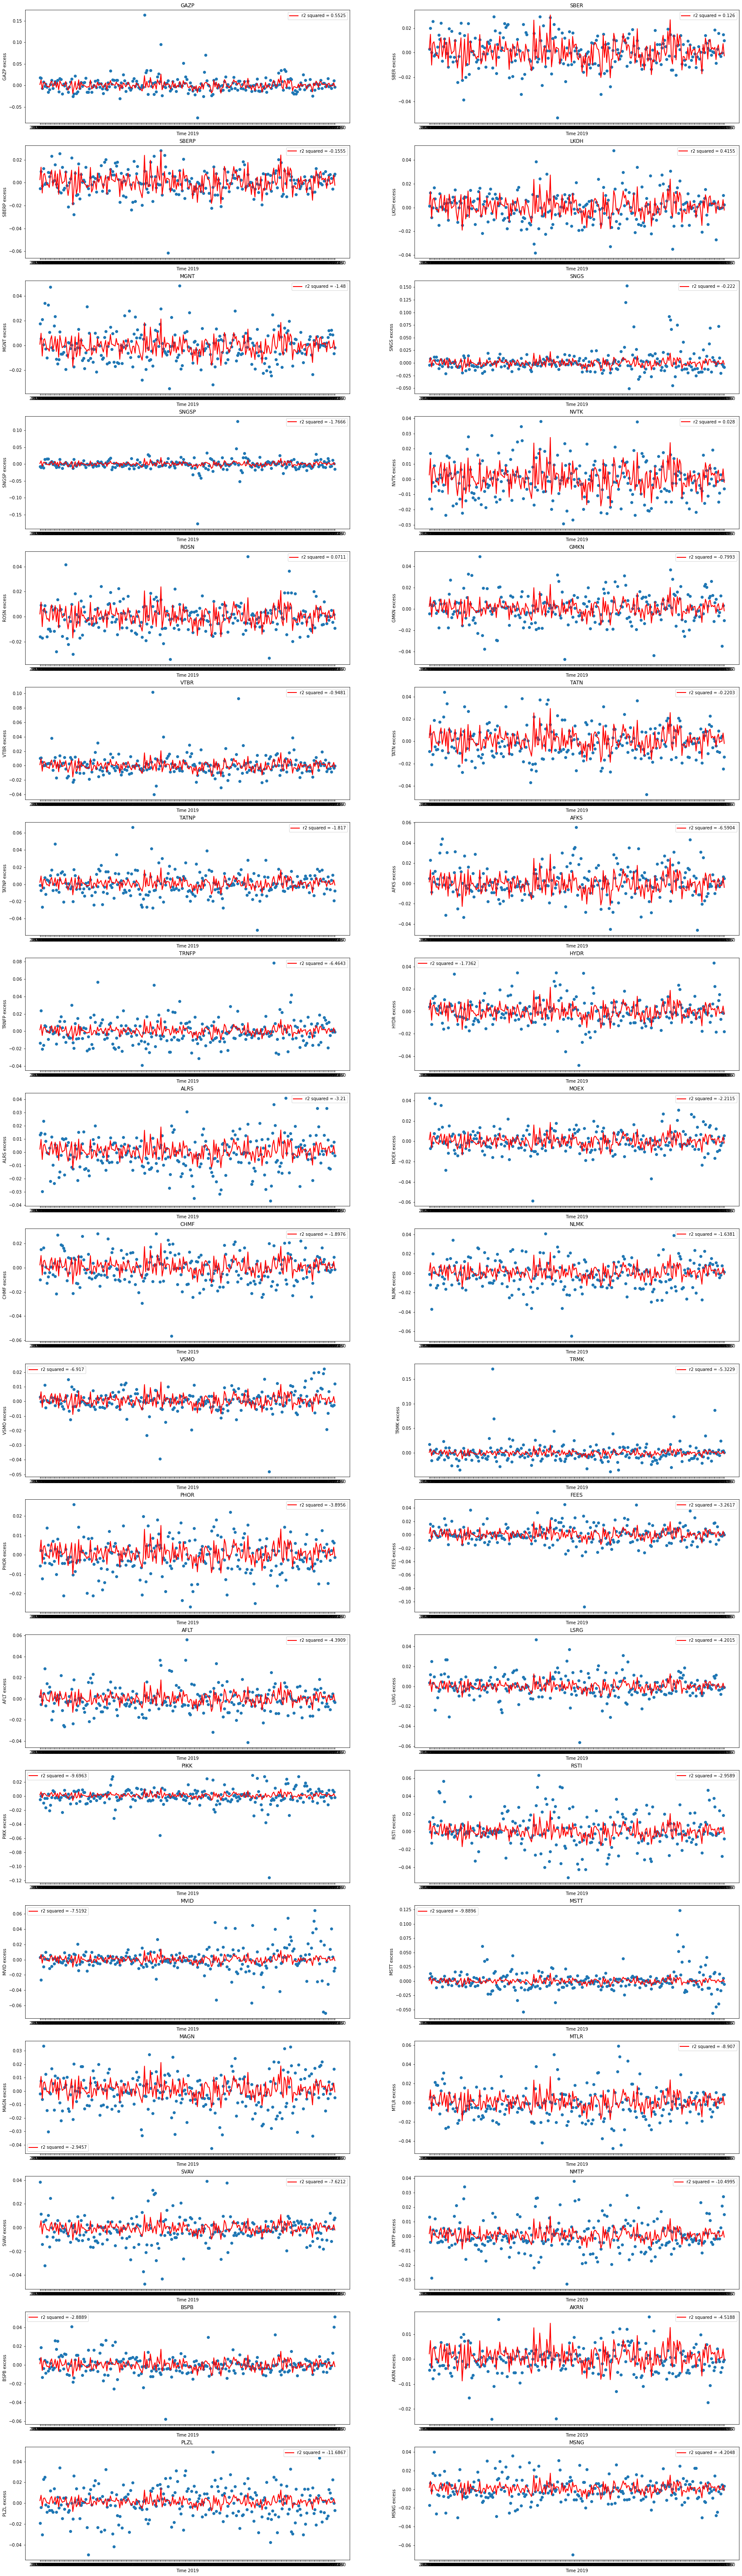

In [274]:
# ПОМЕНЯТЬ

gs = gridspec.GridSpec(19, 2)


fig = plt.figure(figsize=(30,110))
for tick, grd, i in zip(excess_returns.columns,
                        itertools.product(list(range(19)), list(range(2))),
                       range(len(excess_returns.columns))):
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plt.scatter(x = returns['DATE'].astype(str)[1257:], y = excess_returns[tick][1257:])
    plt.plot(returns['DATE'].astype(str)[1257:], prediction[:, i], c='red', linewidth=2, 
             label=f"r2 squared = {round(r2_score(CAPM.predict(X[1257:]), y, multioutput='raw_values')[i], 4)}")
    
    plt.xlabel("Time 2019")
    plt.ylabel(f"{tick} excess")
    plt.legend()
    plt.title(f'{excess_returns.columns[i]}')

plt.show();

## *Дневная доходность с окном в 3 месяца*

#### *Обучение до 2019, на 2019 тестирование*

In [245]:
# Получаем оценку Бета и Альфа для каждого из окон

betas = {}
alphas = {}
for t in range(58):
    m = [m_y[t][0], m_y[t+1][0], m_y[t+2][0]]
    year = [m_y[t][1], m_y[t+1][1], m_y[t+2][1]]
    indices = returns.loc[returns['month'].isin(m)].loc[returns['year'].isin(year)].index
    
    y = excess_returns.loc[indices, :].to_numpy()
    X = market.loc[indices].to_numpy().reshape(-1, 1)
    CAPM = LinearRegression()
    CAPM.fit(X, y)
    
    betas_t = list(zip(excess_returns.columns, CAPM.coef_))
    alphas_t = list(zip(excess_returns.columns, CAPM.intercept_))
    
    for i in range(len(betas_t)):
        betas[betas_t[i][0]] = betas.get(betas_t[i][0], []) + [betas_t[i][1][0]]
        alphas[alphas_t[i][0]] =  alphas.get(alphas_t[i][0], []) + [alphas_t[i][1]]

In [246]:
# Получаем усредненную оценку Бета и Альфа

BETA = []
ALPHA = []
for tick in excess_returns.columns:
    BETA.append(np.mean(np.array(betas[tick])))
    ALPHA.append(np.mean(np.array(alphas[tick])))
BETA = np.array(BETA)
ALPHA = np.array(ALPHA)

In [247]:
# Разделим выборку на тестовую и тренировочную

y_train = excess_returns.loc[:1256, :].to_numpy()
y_test = excess_returns.loc[1257:, :].to_numpy()
X_train = market.loc[:1256].to_numpy().reshape(-1,1)
X_test = market.loc[1257:].to_numpy().reshape(-1,1)

pred_train =  X_train.reshape(-1,1) @ BETA.reshape(-1,1).T + ALPHA.reshape(-1, 1).T
pred_test = X_test.reshape(-1,1) @ BETA.reshape(-1,1).T + ALPHA.reshape(-1, 1).T

In [248]:
print(f"Средний коэффициент \u03B1: {ALPHA.mean()}")

Средний коэффициент α: 0.0002907904879059757


In [249]:
print(f"R2 на тренировочной выборке (2014-2018): {r2_score(pred_train, y_train)}")
print(f"R2 на тестовой выборке (2019): {r2_score(pred_test, y_test)}")

R2 на тренировочной выборке (2014-2018): -6.03323313636941
R2 на тестовой выборке (2019): -8.601122066635181


In [250]:
# Средний показатель MSE
print(f"MSE на тренировочной выборке (2014-2018): {mean_squared_error(pred_train, y_train)}")
print(f"MSE на тестовой выборке (2019): {mean_squared_error(pred_test, y_test)}")

MSE на тренировочной выборке (2014-2018): 0.0003939198159591114
MSE на тестовой выборке (2019): 0.00016749186548740196


## *Месячная доходность*

In [251]:
y = excess_returns_month.to_numpy()
X = market_month.to_numpy().reshape(-1, 1)
CAPM = LinearRegression()
CAPM.fit(X, y)

LinearRegression()

In [252]:
# Коэффициенты Бета
betas_CAPM_month = list(zip(excess_returns_month.columns, CAPM.coef_))

In [253]:
# Коэффициенты Альфа
alphas_CAPM_month = list(zip(excess_returns_month.columns, CAPM.intercept_))

In [254]:
print(f"Средний коэффициент \u03B1: {CAPM.intercept_.mean()}")

Средний коэффициент α: 0.0029418571040678763


In [255]:
# Средний показатель R2
print(f"R2 на выборке (2014-2019): {r2_score(CAPM.predict(X), y)}")

R2 на выборке (2014-2019): -23.26540748855504


In [256]:
# R2 для каждого актива
r2_CAPM_month = list(zip(excess_returns_month.columns, r2_score(CAPM.predict(X), y, multioutput='raw_values')))

In [257]:
# Средний показатель MSE
print(f"R2 на выборке (2014-2019): {mean_squared_error(CAPM.predict(X), y)}")

R2 на выборке (2014-2019): 0.00719534495363716


In [258]:
# MSE для каждого актива
mse_CAPM_month = list(zip(excess_returns_month.columns, mean_squared_error(CAPM.predict(X), y, multioutput='raw_values')))

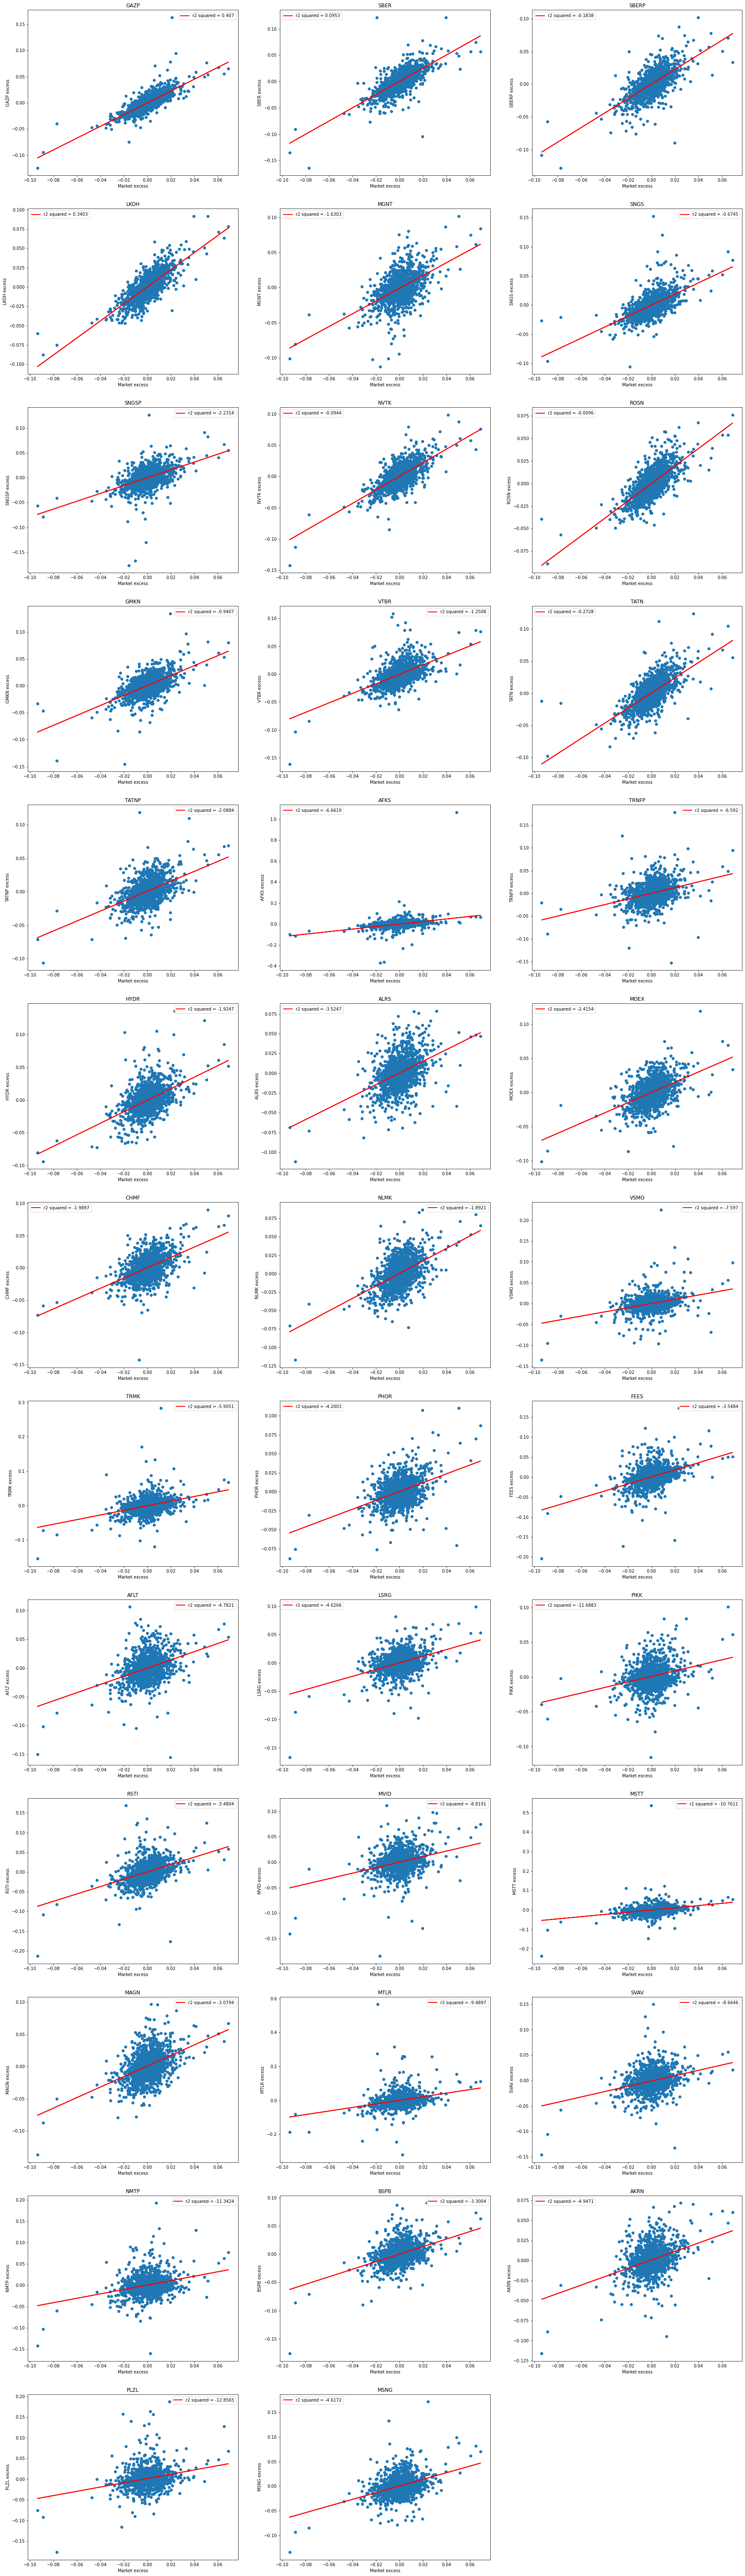

In [241]:
# ПОМЕНЯТЬ

import matplotlib.gridspec as gridspec
import itertools
gs = gridspec.GridSpec(13, 3)

fig = plt.figure(figsize=(30,110))
for tick, grd, i in zip(excess_returns.columns,
                        itertools.product(list(range(13)), list(range(3))),
                       range(len(excess_returns.columns))):
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plt.scatter(x = market_month, y = excess_returns_month[tick])
    plt.plot(market_month, CAPM.predict(X)[:, i], c='red', linewidth=2, 
             label=f"r2 squared = {round(r2_score(CAPM.predict(X), y, multioutput='raw_values')[i], 4)}")
    
    plt.xlabel("Market excess")
    plt.ylabel(f"{tick} excess")
    plt.legend()
    plt.title(f'{excess_returns.columns[i]}')

plt.show();

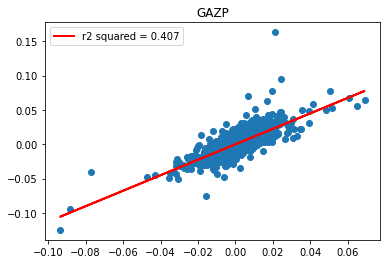

In [21]:
plt.scatter(market, excess_returns['GAZP'])
plt.plot(market, CAPM.predict(X)[:, 0], c='red', linewidth=2, label=f"r2 squared = {round(r2_score(CAPM.predict(X), y, multioutput='raw_values')[0], 4)}")
plt.legend()
plt.title(f'{excess_returns.columns[0]}')
#plt.legend([f'{r2_score(CAPM.predict(X), y, multioutput='raw_values')[0]}'])
plt.show()

#### *Обучение до 2019, на 2019 тестирование*

In [259]:
y = excess_returns_month[:59].to_numpy()
X = market_month.to_numpy()[:59].reshape(-1, 1)
CAPM = LinearRegression()
CAPM.fit(X, y)

LinearRegression()

In [260]:
print(f"Средний коэффициент \u03B1: {CAPM.intercept_.mean()}")

Средний коэффициент α: 0.004651809271014341


In [261]:
prediction = CAPM.predict(market_month.to_numpy()[60:].reshape(-1, 1)) # Предсказание для 2019 года
print(f"R2 на тренировочной выборке (2014-2018): {r2_score(CAPM.predict(X), y)}")
print(f"R2 на тестовой выборке (2019): {r2_score(prediction, excess_returns_month[60:].to_numpy())}")

R2 на тренировочной выборке (2014-2018): -81.07119745032715
R2 на тестовой выборке (2019): -255.86265545135618


In [262]:
# Средний показатель MSE
print(f"MSE на тренировочной выборке (2014-2018): {mean_squared_error(CAPM.predict(X), y)}")
print(f"MSE на тестовой выборке (2019): {mean_squared_error(prediction, excess_returns_month[60:].to_numpy())}")

MSE на тренировочной выборке (2014-2018): 0.007840649611324647
MSE на тестовой выборке (2019): 0.004462528532366024


In [263]:
# MSE для каждого актива
mse_CAPM_month = list(zip(excess_returns.columns, mean_squared_error(prediction, excess_returns_month[60:].to_numpy(), multioutput='raw_values')))

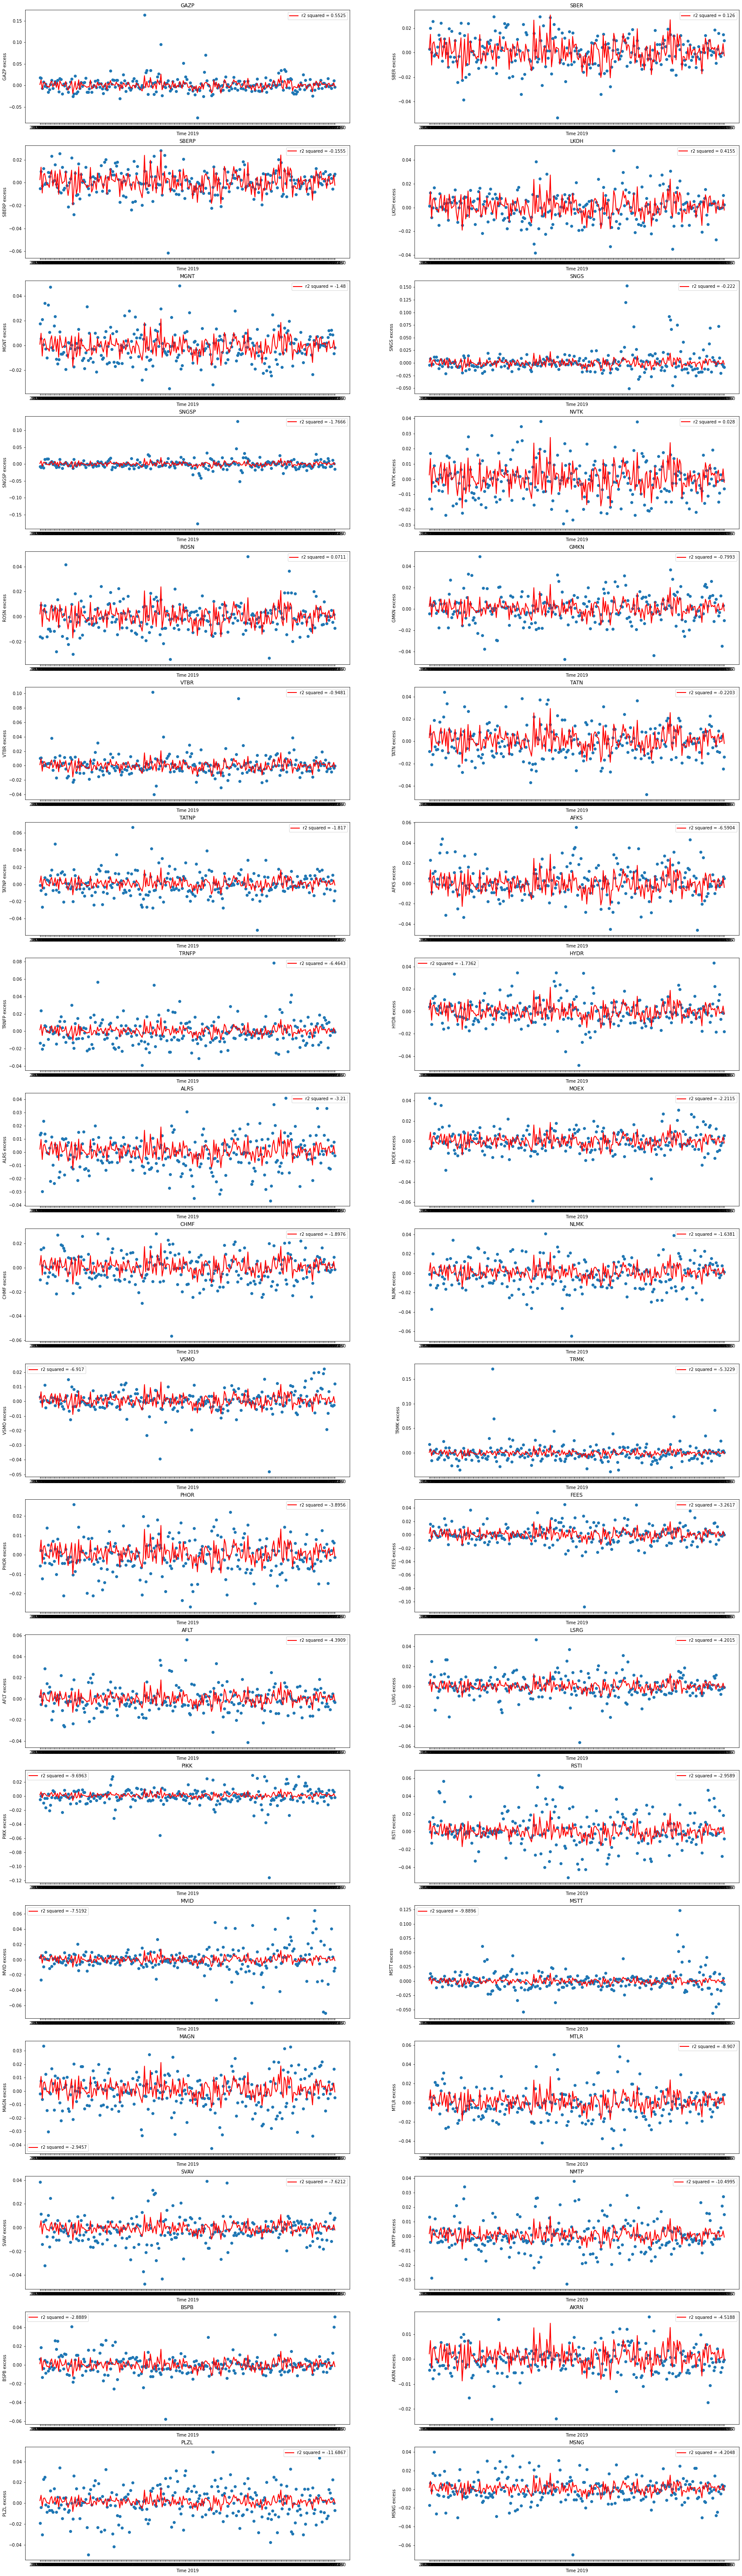

In [274]:
gs = gridspec.GridSpec(19, 2)


fig = plt.figure(figsize=(30,110))
for tick, grd, i in zip(excess_returns.columns,
                        itertools.product(list(range(19)), list(range(2))),
                       range(len(excess_returns.columns))):
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plt.scatter(x = returns['DATE'].astype(str)[1257:], y = excess_returns[tick][1257:])
    plt.plot(returns['DATE'].astype(str)[1257:], prediction[:, i], c='red', linewidth=2, 
             label=f"r2 squared = {round(r2_score(CAPM.predict(X[1257:]), y, multioutput='raw_values')[i], 4)}")
    
    plt.xlabel("Time 2019")
    plt.ylabel(f"{tick} excess")
    plt.legend()
    plt.title(f'{excess_returns.columns[i]}')

plt.show();

# <center> 3 FACTOR </center>

## *Дневная доходность*

### Портфели 2x3

In [264]:
y = excess_returns.to_numpy()
X = pd.DataFrame(market).join(factors_3_23).to_numpy()
Fama_3_23 = LinearRegression()
Fama_3_23.fit(X, y)

LinearRegression()

In [265]:
# Коэффициенты Бета
betas_Fama_3_23 = list(zip(excess_returns.columns, Fama_3_23.coef_))

In [266]:
# Коэффициенты Альфа
alphas_Fama_3_23 = list(zip(excess_returns.columns, Fama_3_23.intercept_))

In [267]:
print(f"Средний коэффициент \u03B1: {Fama_3_23.intercept_.mean()}")

Средний коэффициент α: 0.00012911932231938526


In [268]:
# Средний показатель R2
print(f"R2 на выборке (2014-2019): {r2_score(Fama_3_23.predict(X), y)}")

R2 на выборке (2014-2019): -3.1601495401062243


In [269]:
# R2 для каждого актива
r2_Fama_3_23 = list(zip(excess_returns.columns, r2_score(Fama_3_23.predict(X), y, multioutput='raw_values')))

In [270]:
# Средний показатель MSE
print(f"MSE на выборке (2014-2019): {mean_squared_error(Fama_3_23.predict(X), y)}")

MSE на выборке (2014-2019): 0.00034745103687713945


In [271]:
# MSE для каждого актива
mse_Fama_3_23 = list(zip(excess_returns.columns, mean_squared_error(Fama_3_23.predict(X), y, multioutput='raw_values')))

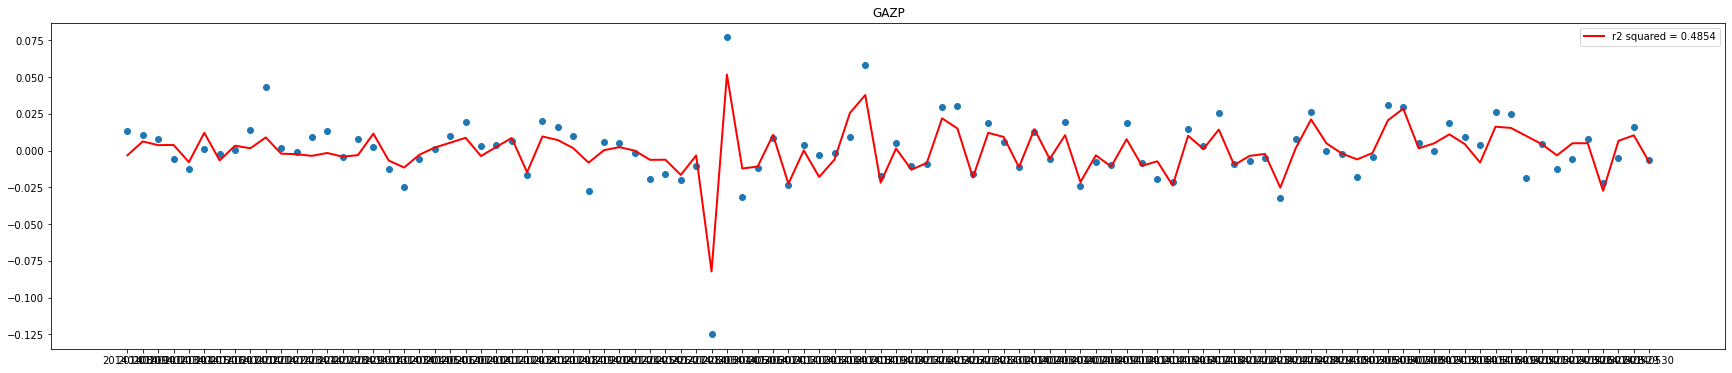

In [281]:
plt.figure(figsize=(30, 6))

plt.scatter(returns['DATE'].astype('str')[:100], excess_returns['GAZP'][:100])
plt.plot(returns['DATE'].astype('str')[:100], Fama_3_23.predict(X)[:100, 0], c='red', linewidth=2, label=f"r2 squared = {round(r2_score(Fama_3_23.predict(X), y, multioutput='raw_values')[0], 4)}")
plt.legend()
plt.title(f'{excess_returns.columns[0]}')

plt.show()


#### *Обучение до 2019, на 2019 тестирование*

In [272]:
y = excess_returns[:1256].to_numpy()
X = pd.DataFrame(market).join(factors_3_23).to_numpy()[:1256]
Fama_3_23 = LinearRegression()
Fama_3_23.fit(X, y)

LinearRegression()

In [273]:
print(f"Средний коэффициент \u03B1: {Fama_3_23.intercept_.mean()}")

Средний коэффициент α: 0.00017628407600268477


In [274]:
prediction = Fama_3_23.predict(pd.DataFrame(market).join(factors_3_23).to_numpy()[1257:]) # Предсказание для 2019 года
print(f"R2 на тренировочной выборке (2014-2018): {r2_score(Fama_3_23.predict(X), y)}")
print(f"R2 на тестовой выборке (2019): {r2_score(prediction, excess_returns[1257:].to_numpy())}")

R2 на тренировочной выборке (2014-2018): -2.909425496779388
R2 на тестовой выборке (2019): -6.244291512662135


In [275]:
# Средний показатель MSE
print(f"MSE на тренировочной выборке (2014-2018): {mean_squared_error(Fama_3_23.predict(X), y)}")
print(f"MSE на тестовой выборке (2019): {mean_squared_error(prediction, excess_returns[1257:].to_numpy())}")

MSE на тренировочной выборке (2014-2018): 0.0003844803305251697
MSE на тестовой выборке (2019): 0.00016433125492000062


In [276]:
# MSE для каждого актива на тестовой выборке
mse_CAPM = list(zip(excess_returns.columns, mean_squared_error(prediction, excess_returns[1257:].to_numpy(), multioutput='raw_values')))

### Портфели 2x2

In [277]:
y = excess_returns.to_numpy()
X = pd.DataFrame(market).join(factors_3_22).to_numpy()
Fama_3_22 = LinearRegression()
Fama_3_22.fit(X, y)

LinearRegression()

In [278]:
# Коэффициенты Бета
betas_Fama_3_22 = list(zip(excess_returns.columns, Fama_3_22.coef_))

In [279]:
# Коэффициенты Альфа
alphas_Fama_3_22 = list(zip(excess_returns.columns, Fama_3_22.intercept_))

In [280]:
print(f"Средний коэффициент \u03B1: {Fama_3_22.intercept_.mean()}")

Средний коэффициент α: 0.0001661278878858878


In [281]:
# Средний показатель R2
print(f"R2 на выборке (2014-2019): {r2_score(Fama_3_22.predict(X), y)}")

R2 на выборке (2014-2019): -2.9424558575789983


In [282]:
# Средний показатель MSE
print(f"MSE на выборке (2014-2019): {mean_squared_error(Fama_3_22.predict(X), y)}")

MSE на выборке (2014-2019): 0.0003447180198605272


In [283]:
# R2 для каждого актива
r2_Fama_3_22 = list(zip(excess_returns.columns, r2_score(Fama_3_22.predict(X), y, multioutput='raw_values')))

In [284]:
# MSE для каждого актива
mse_Fama_3_22 = list(zip(excess_returns.columns, mean_squared_error(Fama_3_22.predict(X), y, multioutput='raw_values')))

#### *Обучение до 2019, на 2019 тестирование*

In [285]:
y = excess_returns[:1256].to_numpy()
X = pd.DataFrame(market).join(factors_3_22).to_numpy()[:1256]
Fama_3_22 = LinearRegression()
Fama_3_22.fit(X, y)

LinearRegression()

In [286]:
print(f"Средний коэффициент \u03B1: {Fama_3_22.intercept_.mean()}")

Средний коэффициент α: 0.00021108004298314625


In [287]:
prediction = Fama_3_22.predict(pd.DataFrame(market).join(factors_3_22).to_numpy()[1257:]) # Предсказание для 2019 года
print(f"R2 на тренировочной выборке (2014-2018): {r2_score(Fama_3_22.predict(X), y)}")
print(f"R2 на тестовой выборке (2019): {r2_score(prediction, excess_returns[1257:].to_numpy())}")

R2 на тренировочной выборке (2014-2018): -2.692286288599948
R2 на тестовой выборке (2019): -5.579590411911856


In [288]:
# Средний показатель MSE
print(f"MSE на тренировочной выборке (2014-2018): {mean_squared_error(Fama_3_22.predict(X), y)}")
print(f"MSE на тестовой выборке (2019): {mean_squared_error(prediction, excess_returns[1257:].to_numpy())}")

MSE на тренировочной выборке (2014-2018): 0.0003810440931673607
MSE на тестовой выборке (2019): 0.00016509631755032205


In [289]:
# MSE для каждого актива
mse_Fama_3_22 = list(zip(excess_returns.columns, mean_squared_error(prediction, excess_returns[1257:].to_numpy(), multioutput='raw_values')))

## *Дневная доходность с окном в 3 месяца*

### Портфели 2x3

In [290]:
# Получаем оценку Бета и Альфа для каждого из окон

betas = {}
alphas = {}
for t in range(58):
    m = [m_y[t][0], m_y[t+1][0], m_y[t+2][0]]
    year = [m_y[t][1], m_y[t+1][1], m_y[t+2][1]]
    indices = returns.loc[returns['month'].isin(m)].loc[returns['year'].isin(year)].index
    
    y = excess_returns.loc[indices, :].to_numpy()
    X = pd.DataFrame(market).join(factors_3_23).loc[indices].to_numpy()
    Fama_3_23 = LinearRegression()
    Fama_3_23.fit(X, y)
    
    betas_t = list(zip(excess_returns.columns, Fama_3_23.coef_))
    alphas_t = list(zip(excess_returns.columns, Fama_3_23.intercept_))
    
    for i in range(len(betas_t)):
        betas[betas_t[i][0]] = betas.get(betas_t[i][0], []) + [betas_t[i][1]]
        alphas[alphas_t[i][0]] =  alphas.get(alphas_t[i][0], []) + [alphas_t[i][1]]

In [291]:
# Получаем усредненную оценку Бета и Альфа
BETA = []
ALPHA = []
for tick in excess_returns.columns:
    BETA.append(np.mean(np.vstack(betas[tick]), axis = 0))
    ALPHA.append(np.mean(np.array(alphas[tick])))
BETA = np.array(BETA)
ALPHA = np.array(ALPHA)

In [292]:
# Разделим выборку на тестовую и тренировочную

y_train = excess_returns.loc[:1256, :].to_numpy()
y_test = excess_returns.loc[1257:, :].to_numpy()

X_train = pd.DataFrame(market).join(factors_3_23).loc[:1256].to_numpy()
X_test = pd.DataFrame(market).join(factors_3_23).loc[1257:].to_numpy()

pred_train =  X_train @ BETA.T + ALPHA.reshape(-1, 1).T
pred_test = X_test @ BETA.T + ALPHA.reshape(-1, 1).T

In [293]:
print(f"Средний коэффициент \u03B1: {ALPHA.mean()}")

Средний коэффициент α: 0.0002637632323094207


In [294]:
print(f"R2 на тренировочной выборке (2014-2018): {r2_score(pred_train, y_train)}")
print(f"R2 на тестовой выборке (2019): {r2_score(pred_test, y_test)}")

R2 на тренировочной выборке (2014-2018): -0.18108604449128549
R2 на тестовой выборке (2019): -7.598206713333986


In [295]:
# Средний показатель MSE
print(f"MSE на тренировочной выборке (2014-2018): {mean_squared_error(pred_train, y_train)}")
print(f"MSE на тестовой выборке (2019): {mean_squared_error(pred_test, y_test)}")

MSE на тренировочной выборке (2014-2018): 0.01972813721373648
MSE на тестовой выборке (2019): 0.00016365775371281178


### Портфели 2x2

In [296]:
# Получаем оценку Бета и Альфа для каждого из окон

betas = {}
alphas = {}
for t in range(58):
    m = [m_y[t][0], m_y[t+1][0], m_y[t+2][0]]
    year = [m_y[t][1], m_y[t+1][1], m_y[t+2][1]]
    indices = returns.loc[returns['month'].isin(m)].loc[returns['year'].isin(year)].index
    
    y = excess_returns.loc[indices, :].to_numpy()
    X = pd.DataFrame(market).join(factors_3_22).loc[indices].to_numpy()
    Fama_3_22 = LinearRegression()
    Fama_3_22.fit(X, y)
    
    betas_t = list(zip(excess_returns.columns, Fama_3_22.coef_))
    alphas_t = list(zip(excess_returns.columns, Fama_3_22.intercept_))
    
    for i in range(len(betas_t)):
        betas[betas_t[i][0]] = betas.get(betas_t[i][0], []) + [betas_t[i][1]]
        alphas[alphas_t[i][0]] =  alphas.get(alphas_t[i][0], []) + [alphas_t[i][1]]

In [297]:
# Получаем усредненную оценку Бета и Альфа
BETA = []
ALPHA = []
for tick in excess_returns.columns:
    BETA.append(np.mean(np.vstack(betas[tick]), axis = 0))
    ALPHA.append(np.mean(np.array(alphas[tick])))
BETA = np.array(BETA)
ALPHA = np.array(ALPHA)

In [298]:
# Разделим выборку на тестовую и тренировочную

y_train = excess_returns.loc[:1256, :].to_numpy()
y_test = excess_returns.loc[1257:, :].to_numpy()

X_train = pd.DataFrame(market).join(factors_3_22).loc[:1256].to_numpy()
X_test = pd.DataFrame(market).join(factors_3_22).loc[1257:].to_numpy()

pred_train =  X_train @ BETA.T + ALPHA.reshape(-1, 1).T
pred_test = X_test @ BETA.T + ALPHA.reshape(-1, 1).T

In [299]:
print(f"Средний коэффициент \u03B1: {ALPHA.mean()}")

Средний коэффициент α: 0.00021182477877350488


In [300]:
print(f"R2 на тренировочной выборке (2014-2018): {r2_score(pred_train, y_train)}")
print(f"R2 на тестовой выборке (2019): {r2_score(pred_test, y_test)}")

R2 на тренировочной выборке (2014-2018): -0.5374708726808161
R2 на тестовой выборке (2019): -7.713503299051334


In [301]:
# Средний показатель MSE
print(f"MSE на тренировочной выборке (2014-2018): {mean_squared_error(pred_train, y_train)}")
print(f"MSE на тестовой выборке (2019): {mean_squared_error(pred_test, y_test)}")

MSE на тренировочной выборке (2014-2018): 0.007495309593979858
MSE на тестовой выборке (2019): 0.00016228095647680336


## *Месячная доходность*

### Портфели 2x3

In [302]:
y = excess_returns_month.to_numpy()
X = pd.DataFrame(market_month).join(factors_3_23_month).to_numpy()
Fama_3_23 = LinearRegression()
Fama_3_23.fit(X, y)

LinearRegression()

In [303]:
# Коэффициенты Бета
betas_Fama_3_23_month = list(zip(excess_returns_month.columns, Fama_3_23.coef_))

In [304]:
# Коэффициенты Альфа
alphas_Fama_3_23_month = list(zip(excess_returns_month.columns, Fama_3_23.intercept_))

In [305]:
print(f"Средний коэффициент \u03B1: {Fama_3_23.intercept_.mean()}")

Средний коэффициент α: 0.002185027364477459


In [306]:
# Средний показатель R2
print(f"R2 на выборке (2014-2019): {r2_score(Fama_3_23.predict(X), y)}")

R2 на выборке (2014-2019): -3.6685074190660796


In [307]:
# Средний показатель MSE
print(f"MSE на выборке (2014-2019): {mean_squared_error(Fama_3_23.predict(X), y)}")

MSE на выборке (2014-2019): 0.006615307455420325


In [308]:
# R2 для каждого актива
r2_Fama_3_23_month = list(zip(excess_returns.columns, r2_score(Fama_3_23.predict(X), y, multioutput='raw_values')))

In [309]:
# MSE для каждого актива
mse_Fama_3_23_month = list(zip(excess_returns.columns, mean_squared_error(Fama_3_23.predict(X), y, multioutput='raw_values')))

ValueError: x and y must have same first dimension, but have shapes (100,) and (72,)

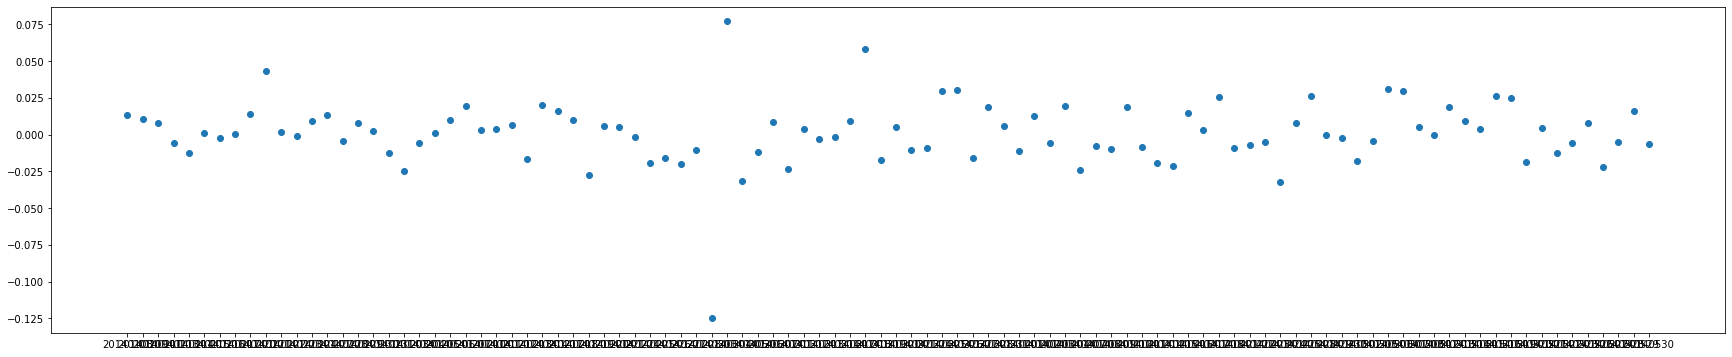

In [310]:
plt.figure(figsize=(30, 6))

plt.scatter(returns['DATE'].astype('str')[:100], excess_returns['GAZP'][:100])
plt.plot(returns['DATE'].astype('str')[:100], Fama_3_23.predict(X)[:100, 0], c='red', linewidth=2, label=f"r2 squared = {round(r2_score(Fama_3_23.predict(X), y, multioutput='raw_values')[0], 4)}")
plt.legend()
plt.title(f'{excess_returns.columns[0]}')

plt.show()


#### *Обучение до 2019, на 2019 тестирование*

In [311]:
y = excess_returns_month[:59].to_numpy()
X = pd.DataFrame(market_month).join(factors_3_23_month).to_numpy()[:59]
Fama_3_23 = LinearRegression()
Fama_3_23.fit(X, y)

LinearRegression()

In [312]:
print(f"Средний коэффициент \u03B1: {Fama_3_23.intercept_.mean()}")

Средний коэффициент α: 0.003420004067422751


In [313]:
prediction = Fama_3_23.predict(pd.DataFrame(market_month).join(factors_3_23_month).to_numpy()[60:]) # Предсказание для 2019 года
print(f"R2 на тренировочной выборке (2014-2018): {r2_score(Fama_3_23.predict(X), y)}")
print(f"R2 на тестовой выборке (2019): {r2_score(prediction, excess_returns_month[60:].to_numpy())}")

R2 на тренировочной выборке (2014-2018): -3.1694231912206865
R2 на тестовой выборке (2019): -12.211558112721518


In [314]:
# Средний показатель MSE
print(f"MSE на тренировочной выборке (2014-2018): {mean_squared_error(Fama_3_23.predict(X), y)}")
print(f"MSE на тестовой выборке (2019): {mean_squared_error(prediction, excess_returns_month[60:].to_numpy())}")

MSE на тренировочной выборке (2014-2018): 0.0072006829588805695
MSE на тестовой выборке (2019): 0.0041497139728391376


In [315]:
# R2 для каждого актива
r2_Fama_3_23_month = list(zip(excess_returns.columns, r2_score(prediction, excess_returns_month[60:].to_numpy(), multioutput='raw_values')))

In [316]:
# MSE для каждого актива
mse_Fama_3_23_month = list(zip(excess_returns_month.columns, mean_squared_error(prediction, excess_returns_month[60:].to_numpy(), multioutput='raw_values')))

### Портфели 2x2

In [317]:
y = excess_returns_month.to_numpy()
X = pd.DataFrame(market_month).join(factors_3_22_month).to_numpy()
Fama_3_22 = LinearRegression()
Fama_3_22.fit(X, y)

LinearRegression()

In [318]:
# Коэффициенты Бета
betas_Fama_3_22_month = list(zip(excess_returns.columns, Fama_3_22.coef_))

In [319]:
# Коэффициенты Альфа
alphas_Fama_3_22_month = list(zip(excess_returns.columns, Fama_3_22.intercept_))

In [320]:
print(f"Средний коэффициент \u03B1: {Fama_3_22.intercept_.mean()}")

Средний коэффициент α: 0.0032816243388086083


In [321]:
print(f"R2 на тренировочной выборке (2014-2019): {r2_score(Fama_3_22.predict(X), y)}")

R2 на тренировочной выборке (2014-2019): -5.239200916701205


In [322]:
# Средний показатель MSE
print(f"MSE на тренировочной выборке (2014-2019): {mean_squared_error(Fama_3_22.predict(X), y)}")

MSE на тренировочной выборке (2014-2019): 0.006611346067792531


In [323]:
# R2 для каждого актива
r2_Fama_3_22_month = list(zip(excess_returns.columns, r2_score(Fama_3_22.predict(X), y, multioutput='raw_values')))

In [324]:
# MSE для каждого актива
mse_Fama_3_22_month = list(zip(excess_returns.columns, mean_squared_error(Fama_3_22.predict(X), y, multioutput='raw_values')))

#### *Обучение до 2019, на 2019 тестирование*

In [325]:
y = excess_returns_month[:59].to_numpy()
X = pd.DataFrame(market_month).join(factors_3_22_month).to_numpy()[:59]
Fama_3_22 = LinearRegression()
Fama_3_22.fit(X, y)

LinearRegression()

In [326]:
print(f"Средний коэффициент \u03B1: {Fama_3_22.intercept_.mean()}")

Средний коэффициент α: 0.0046228252462388545


In [327]:
prediction = Fama_3_22.predict(pd.DataFrame(market_month).join(factors_3_22_month).to_numpy()[60:]) # Предсказание для 2019 года
print(f"R2 на тренировочной выборке (2014-2018): {r2_score(Fama_3_22.predict(X), y)}")
print(f"R2 на тестовой выборке (2019): {r2_score(prediction, excess_returns_month[60:].to_numpy())}")

R2 на тренировочной выборке (2014-2018): -4.646702303996194
R2 на тестовой выборке (2019): -10.169754781944102


In [328]:
# Средний показатель MSE
print(f"MSE на тренировочной выборке (2014-2018): {mean_squared_error(Fama_3_22.predict(X), y)}")
print(f"MSE на тестовой выборке (2019): {mean_squared_error(prediction, excess_returns_month[60:].to_numpy())}")

MSE на тренировочной выборке (2014-2018): 0.007180943882413225
MSE на тестовой выборке (2019): 0.004240747008458129


In [329]:
# R2 для каждого актива
r2_Fama_3_22_month = list(zip(excess_returns.columns, r2_score(prediction, excess_returns_month[60:].to_numpy(), multioutput='raw_values')))

In [330]:
# MSE для каждого актива
mse_Fama_3_22_month = list(zip(excess_returns_month.columns, mean_squared_error(prediction, excess_returns_month[60:].to_numpy(), multioutput='raw_values')))

# <center> 5 FACTOR </center>

## *Дневная доходность*

### Портфели 2x3

In [331]:
y = excess_returns.to_numpy()
X = pd.DataFrame(market).join(factors_5_23).to_numpy()
Fama_5_23 = LinearRegression()
Fama_5_23.fit(X, y)

LinearRegression()

In [332]:
# Коэффициенты Бета
betas_Fama_5_23 = list(zip(excess_returns.columns, Fama_5_23.coef_))

In [333]:
# Коэффициенты Альфа
alphas_Fama_5_23 = list(zip(excess_returns.columns, Fama_5_23.intercept_))

In [334]:
print(f"Средний коэффициент \u03B1: {Fama_5_23.intercept_.mean()}")

Средний коэффициент α: 0.00014663381596142743


In [335]:
# Средний показатель R2
print(f"R2 на выборке (2014-2019): {r2_score(Fama_5_23.predict(X), y)}")

R2 на выборке (2014-2019): -2.5581857705848936


In [336]:
# R2 для каждого актива
r2_Fama_5_23 = list(zip(excess_returns.columns, r2_score(Fama_5_23.predict(X), y, multioutput='raw_values')))

In [337]:
# Средний показатель MSE
print(f"R2 на выборке (2014-2019): {mean_squared_error(Fama_5_23.predict(X), y)}")

R2 на выборке (2014-2019): 0.0003359859980807676


In [338]:
# MSE для каждого актива
mse_Fama_3_23 = list(zip(excess_returns.columns, mean_squared_error(Fama_5_23.predict(X), y, multioutput='raw_values')))

#### *Обучение до 2019, на 2019 тестирование*

In [339]:
y = excess_returns[:1256].to_numpy()
X = pd.DataFrame(market).join(factors_5_23).to_numpy()[:1256]
Fama_5_23 = LinearRegression()
Fama_5_23.fit(X, y)

LinearRegression()

In [340]:
print(f"Средний коэффициент \u03B1: {Fama_5_23.intercept_.mean()}")

Средний коэффициент α: 0.00016473163167877506


In [341]:
prediction = Fama_5_23.predict(pd.DataFrame(market).join(factors_5_23).to_numpy()[1257:]) # Предсказание для 2019 года
print(f"R2 на тренировочной выборке (2014-2018): {r2_score(Fama_5_23.predict(X), y)}")
print(f"R2 на тестовой выборке (2019): {r2_score(prediction, excess_returns[1257:].to_numpy())}")

R2 на тренировочной выборке (2014-2018): -2.3008809502165843
R2 на тестовой выборке (2019): -4.827971567067597


In [342]:
# Средний показатель MSE
print(f"MSE на тренировочной выборке (2014-2018): {mean_squared_error(Fama_5_23.predict(X), y)}")
print(f"MSE на тестовой выборке (2019): {mean_squared_error(prediction, excess_returns[1257:].to_numpy())}")

MSE на тренировочной выборке (2014-2018): 0.0003698806937483262
MSE на тестовой выборке (2019): 0.00017213189904206417


In [343]:
# Средний показатель MSE
mean_squared_error(prediction, excess_returns[1257:].to_numpy())

0.00017213189904206417

In [344]:
# MSE для каждого актива
mse_Fama_5_23 = list(zip(excess_returns.columns, mean_squared_error(prediction, excess_returns[1257:].to_numpy(), multioutput='raw_values')))

### Портфели 2x2

In [345]:
y = excess_returns.to_numpy()
X = pd.DataFrame(market).join(factors_5_22).to_numpy()
Fama_5_22 = LinearRegression()
Fama_5_22.fit(X, y)

LinearRegression()

In [346]:
# Коэффициенты Бета
betas_Fama_5_22 = list(zip(excess_returns.columns, Fama_5_22.coef_))

In [347]:
# Коэффициенты Альфа
alphas_Fama_5_22 = list(zip(excess_returns.columns, Fama_5_22.intercept_))

In [348]:
print(f"Средний коэффициент \u03B1: {Fama_5_22.intercept_.mean()}")

Средний коэффициент α: 0.00015857394908413785


In [349]:
# Средний показатель R2
print(f"R2 на выборке (2014-2019): {r2_score(Fama_5_22.predict(X), y)}")

R2 на выборке (2014-2019): -2.510845826706827


In [350]:
# R2 для каждого актива
r2_Fama_5_22 = list(zip(excess_returns.columns, r2_score(Fama_5_22.predict(X), y, multioutput='raw_values')))

In [351]:
# Средний показатель MSE
print(f"R2 на выборке (2014-2019): {mean_squared_error(Fama_5_22.predict(X), y)}")

R2 на выборке (2014-2019): 0.0003347282216838093


In [353]:
# MSE для каждого актива
mse_Fama_5_22 = list(zip(excess_returns.columns, mean_squared_error(Fama_5_22.predict(X), y, multioutput='raw_values')))

In [354]:
# MSE для каждого актива
mse_Fama_5_22 = list(zip(excess_returns.columns, mean_squared_error(Fama_5_22.predict(X), y, multioutput='raw_values')))

#### *Обучение до 2019, на 2019 тестирование*

In [355]:
y = excess_returns[:1256].to_numpy()
X = pd.DataFrame(market).join(factors_5_22).to_numpy()[:1256]
Fama_5_22 = LinearRegression()
Fama_5_22.fit(X, y)

LinearRegression()

In [356]:
print(f"Средний коэффициент \u03B1: {Fama_5_22.intercept_.mean()}")

Средний коэффициент α: 0.00018783609661766743


In [357]:
prediction = Fama_5_22.predict(pd.DataFrame(market).join(factors_5_22).to_numpy()[1257:]) # Предсказание для 2019 года
print(f"R2 на тренировочной выборке (2014-2018): {r2_score(Fama_5_22.predict(X), y)}")
print(f"R2 на тестовой выборке (2019): {r2_score(prediction, excess_returns[1257:].to_numpy())}")

R2 на тренировочной выборке (2014-2018): -2.2592939089144712
R2 на тестовой выборке (2019): -4.4787230983688575


In [358]:
# Средний показатель MSE
print(f"MSE на тренировочной выборке (2014-2018): {mean_squared_error(Fama_5_22.predict(X), y)}")
print(f"MSE на тестовой выборке (2019): {mean_squared_error(prediction, excess_returns[1257:].to_numpy())}")

MSE на тренировочной выборке (2014-2018): 0.0003682288560453608
MSE на тестовой выборке (2019): 0.00017540754239474938


In [359]:
# MSE для каждого актива
mse_Fama_3_22 = list(zip(excess_returns.columns, mean_squared_error(prediction, excess_returns[1257:].to_numpy(), multioutput='raw_values')))

## *Дневная доходность с окном в 3 месяца*

### Портфели 2x3

In [360]:
# Получаем оценку Бета и Альфа для каждого из окон

betas = {}
alphas = {}
for t in range(58):
    m = [m_y[t][0], m_y[t+1][0], m_y[t+2][0]]
    year = [m_y[t][1], m_y[t+1][1], m_y[t+2][1]]
    indices = returns.loc[returns['month'].isin(m)].loc[returns['year'].isin(year)].index
    
    y = excess_returns.loc[indices, :].to_numpy()
    X = pd.DataFrame(market).join(factors_5_23).loc[indices].to_numpy()
    Fama_5_23 = LinearRegression()
    Fama_5_23.fit(X, y)
    
    betas_t = list(zip(excess_returns.columns, Fama_5_23.coef_))
    alphas_t = list(zip(excess_returns.columns, Fama_5_23.intercept_))
    
    for i in range(len(betas_t)):
        betas[betas_t[i][0]] = betas.get(betas_t[i][0], []) + [betas_t[i][1]]
        alphas[alphas_t[i][0]] =  alphas.get(alphas_t[i][0], []) + [alphas_t[i][1]]

In [361]:
# Получаем усредненную оценку Бета и Альфа
BETA = []
ALPHA = []
for tick in excess_returns.columns:
    BETA.append(np.mean(np.vstack(betas[tick]), axis = 0))
    ALPHA.append(np.mean(np.array(alphas[tick])))
BETA = np.array(BETA)
ALPHA = np.array(ALPHA)

In [362]:
# Разделим выборку на тестовую и тренировочную

y_train = excess_returns.loc[:1256, :].to_numpy()
y_test = excess_returns.loc[1257:, :].to_numpy()

X_train = pd.DataFrame(market).join(factors_5_23).loc[:1256].to_numpy()
X_test = pd.DataFrame(market).join(factors_5_23).loc[1257:].to_numpy()

pred_train =  X_train @ BETA.T + ALPHA.reshape(-1, 1).T
pred_test = X_test @ BETA.T + ALPHA.reshape(-1, 1).T

In [363]:
print(f"R2 на тренировочной выборке (2014-2018): {r2_score(pred_train, y_train)}")
print(f"R2 на тестовой выборке (2019): {r2_score(pred_test, y_test)}")

R2 на тренировочной выборке (2014-2018): -0.45739603086646186
R2 на тестовой выборке (2019): -5.400604986363938


In [364]:
print(f"MSE на тренировочной выборке (2014-2018): {mean_squared_error(pred_train, y_train)}")
print(f"MSE на тестовой выборке (2019): {mean_squared_error(pred_test, y_test)}")

MSE на тренировочной выборке (2014-2018): 0.017573155890428464
MSE на тестовой выборке (2019): 0.0001653990044754259


### Портфели 2x2

In [365]:
# Получаем оценку Бета и Альфа для каждого из окон

betas = {}
alphas = {}
for t in range(58):
    m = [m_y[t][0], m_y[t+1][0], m_y[t+2][0]]
    year = [m_y[t][1], m_y[t+1][1], m_y[t+2][1]]
    indices = returns.loc[returns['month'].isin(m)].loc[returns['year'].isin(year)].index
    
    y = excess_returns.loc[indices, :].to_numpy()
    X = pd.DataFrame(market).join(factors_5_22).loc[indices].to_numpy()
    Fama_5_22 = LinearRegression()
    Fama_5_22.fit(X, y)
    
    betas_t = list(zip(excess_returns.columns, Fama_5_22.coef_))
    alphas_t = list(zip(excess_returns.columns, Fama_5_22.intercept_))
    
    for i in range(len(betas_t)):
        betas[betas_t[i][0]] = betas.get(betas_t[i][0], []) + [betas_t[i][1]]
        alphas[alphas_t[i][0]] =  alphas.get(alphas_t[i][0], []) + [alphas_t[i][1]]

In [366]:
# Получаем усредненную оценку Бета и Альфа
BETA = []
ALPHA = []
for tick in excess_returns.columns:
    BETA.append(np.mean(np.vstack(betas[tick]), axis = 0))
    ALPHA.append(np.mean(np.array(alphas[tick])))
BETA = np.array(BETA)
ALPHA = np.array(ALPHA)

In [367]:
# Разделим выборку на тестовую и тренировочную

y_train = excess_returns.loc[:1256, :].to_numpy()
y_test = excess_returns.loc[1257:, :].to_numpy()

X_train = pd.DataFrame(market).join(factors_5_22).loc[:1256].to_numpy()
X_test = pd.DataFrame(market).join(factors_5_22).loc[1257:].to_numpy()

pred_train =  X_train @ BETA.T + ALPHA.reshape(-1, 1).T
pred_test = X_test @ BETA.T + ALPHA.reshape(-1, 1).T

In [368]:
print(f"R2 на тренировочной выборке (2014-2018): {r2_score(pred_train, y_train)}")
print(f"R2 на тестовой выборке (2019): {r2_score(pred_test, y_test)}")

R2 на тренировочной выборке (2014-2018): -0.3571615842043486
R2 на тестовой выборке (2019): -5.008289600612332


In [369]:
print(f"MSE на тренировочной выборке (2014-2018): {mean_squared_error(pred_train, y_train)}")
print(f"MSE на тестовой выборке (2019): {mean_squared_error(pred_test, y_test)}")

MSE на тренировочной выборке (2014-2018): 0.010117264686718433
MSE на тестовой выборке (2019): 0.00015968680961868937


-5.008289600612332

## *Месячная доходность*

### Портфели 2x3

In [370]:
y = excess_returns_month.to_numpy()
X = pd.DataFrame(market_month).join(factors_5_23_month).to_numpy()
Fama_5_23 = LinearRegression()
Fama_5_23.fit(X, y)

LinearRegression()

In [371]:
# Коэффициенты Бета
betas_Fama_5_23_month = list(zip(excess_returns.columns, Fama_5_23.coef_))

In [372]:
# Коэффициенты Альфа
alphas_Fama_5_23_month = list(zip(excess_returns.columns, Fama_5_23.intercept_))

In [373]:
print(f"Средний коэффициент \u03B1: {Fama_5_23.intercept_.mean()}")

Средний коэффициент α: 0.0022371690470290207


In [374]:
# Средний показатель R2
print(f"R2 на выборке(2014-2019): {r2_score(Fama_5_23.predict(X), y)}")

R2 на выборке(2014-2019): -2.1072368582957957


In [375]:
# R2 для каждого актива
r2_Fama_5_23_month = list(zip(excess_returns.columns, r2_score(Fama_5_23.predict(X), y, multioutput='raw_values')))

In [376]:
# Средний показатель MSE
print(f"MSE на выборке(2014-2019): {mean_squared_error(Fama_5_23.predict(X), y)}")

MSE на выборке(2014-2019): 0.00587864700007064


In [377]:
# MSE для каждого актива
mse_Fama_5_23_month = list(zip(excess_returns.columns, mean_squared_error(Fama_5_23.predict(X), y, multioutput='raw_values')))

#### *Обучение до 2019, на 2019 тестирование*

In [378]:
y = excess_returns_month[:59].to_numpy()
X = pd.DataFrame(market_month).join(factors_5_23_month).to_numpy()[:59]
Fama_5_23 = LinearRegression()
Fama_5_23.fit(X, y)

LinearRegression()

In [379]:
print(f"Средний коэффициент \u03B1: {Fama_5_23.intercept_.mean()}")

Средний коэффициент α: 0.00222745459479632


In [380]:
prediction = Fama_5_23.predict(pd.DataFrame(market_month).join(factors_5_23_month).to_numpy()[60:]) # Предсказание для 2019 года
print(f"R2 на тренировочной выборке (2014-2018): {r2_score(Fama_5_23.predict(X), y)}")
print(f"R2 на тестовой выборке (2019): {r2_score(prediction, excess_returns_month[60:].to_numpy())}")

R2 на тренировочной выборке (2014-2018): -1.7170504602801344
R2 на тестовой выборке (2019): -5.471592692072545


In [381]:
# Средний показатель MSE
print(f"MSE на тренировочной выборке (2014-2018): {mean_squared_error(Fama_5_23.predict(X), y)}")
print(f"MSE на тестовой выборке (2019): {mean_squared_error(prediction, excess_returns_month[60:].to_numpy())}")

MSE на тренировочной выборке (2014-2018): 0.006191514310840771
MSE на тестовой выборке (2019): 0.005156361342733569


In [382]:
# MSE для каждого актива
mse_Fama_5_23 = list(zip(excess_returns.columns, mean_squared_error(prediction, excess_returns_month[60:].to_numpy(), multioutput='raw_values')))

### Портфели 2x2

In [383]:
y = excess_returns_month.to_numpy()
X = pd.DataFrame(market_month).join(factors_5_22_month).to_numpy()
Fama_5_22 = LinearRegression()
Fama_5_22.fit(X, y)

LinearRegression()

In [384]:
# Коэффициенты Бета
betas_Fama_5_22_month = list(zip(excess_returns.columns, Fama_5_22.coef_))

In [385]:
# Коэффициенты Альфа
alphas_Fama_5_22_month = list(zip(excess_returns.columns, Fama_5_22.intercept_))

In [388]:
print(f"Средний коэффициент \u03B1: {Fama_5_22.intercept_.mean()}")

Средний коэффициент α: 0.0030902867965768265


In [389]:
# Средний показатель R2
print(f"R2 на выборке(2014-2019): {r2_score(Fama_5_22.predict(X), y)}")

R2 на выборке(2014-2019): -2.3632592333033813


In [390]:
# R2 для каждого актива
r2_Fama_5_22_month = list(zip(excess_returns.columns, r2_score(Fama_5_22.predict(X), y, multioutput='raw_values')))

In [391]:
# Средний показатель MSE
print(f"MSE на выборке(2014-2019): {mean_squared_error(Fama_5_22.predict(X), y)}")

MSE на выборке(2014-2019): 0.006242839459000141


In [392]:
# MSE для каждого актива
mse_Fama_5_22_month = list(zip(excess_returns.columns, mean_squared_error(Fama_5_22.predict(X), y, multioutput='raw_values')))

#### *Обучение до 2019, на 2019 тестирование*

In [393]:
y = excess_returns_month[:59].to_numpy()
X = pd.DataFrame(market_month).join(factors_5_22_month).to_numpy()[:59]
Fama_5_22 = LinearRegression()
Fama_5_22.fit(X, y)

LinearRegression()

In [394]:
print(f"Средний коэффициент \u03B1: {Fama_5_22.intercept_.mean()}")

Средний коэффициент α: 0.003896890135063975


In [395]:
prediction = Fama_5_22.predict(pd.DataFrame(market_month).join(factors_5_22_month).to_numpy()[60:]) # Предсказание для 2019 года
print(f"R2 на тренировочной выборке (2014-2018): {r2_score(Fama_5_22.predict(X), y)}")
print(f"R2 на тестовой выборке (2019): {r2_score(prediction, excess_returns_month[60:].to_numpy())}")

R2 на тренировочной выборке (2014-2018): -2.156506544025911
R2 на тестовой выборке (2019): -4.960617948633202


In [396]:
# Средний показатель MSE
print(f"MSE на тренировочной выборке (2014-2018): {mean_squared_error(Fama_5_22.predict(X), y)}")
print(f"MSE на тестовой выборке (2019): {mean_squared_error(prediction, excess_returns_month[60:].to_numpy())}")

MSE на тренировочной выборке (2014-2018): 0.00670150704076742
MSE на тестовой выборке (2019): 0.005116762742304527


In [397]:
# MSE для каждого актива
mse_Fama_3_22_month = list(zip(excess_returns.columns, mean_squared_error(prediction, excess_returns_month[60:].to_numpy(), multioutput='raw_values')))